In [1]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
df = pd.read_csv('01_basic_prediction.csv', index_col=0)
df.index=df.index.astype('datetime64[ns]')

In [2]:
df['pm_filled']=df.y_train.fillna(df.y_prediction, inplace=False)
df.head()

,y_train,y_prediction,dew,temp,press,w_speed,snow,rain,w_dir_ne,w_dir_nw,w_dir_se,w_dir_cv,pm_filled
date,,,,,,,,,,,,,
2010-01-02 00:00:00,129.0,96.105760,-16.0,-4.0,1020.0,1.79,0.0,0.0,0.0,0.0,1.0,0.0,129.0
2010-01-02 01:00:00,148.0,98.865247,-15.0,-4.0,1020.0,2.68,0.0,0.0,0.0,0.0,1.0,0.0,148.0
2010-01-02 02:00:00,159.0,168.719903,-11.0,-5.0,1021.0,3.57,0.0,0.0,0.0,0.0,1.0,0.0,159.0
2010-01-02 03:00:00,181.0,267.423175,-7.0,-5.0,1022.0,5.36,1.0,0.0,0.0,0.0,1.0,0.0,181.0
2010-01-02 04:00:00,138.0,267.423175,-7.0,-5.0,1022.0,6.25,2.0,0.0,0.0,0.0,1.0,0.0,138.0


In [3]:
df=df.drop(['y_train','y_prediction'],axis=1)
df[519:].head()

,dew,temp,press,w_speed,snow,rain,w_dir_ne,w_dir_nw,w_dir_se,w_dir_cv,pm_filled
date,,,,,,,,,,,
2010-01-23 15:00:00,-19.0,3.0,1024.0,79.15,0.0,0.0,0.0,1.0,0.0,0.0,17.000000
2010-01-23 16:00:00,-19.0,3.0,1024.0,86.30,0.0,0.0,0.0,1.0,0.0,0.0,22.000000
2010-01-23 17:00:00,-18.0,2.0,1024.0,91.22,0.0,0.0,0.0,1.0,0.0,0.0,21.302637
2010-01-23 18:00:00,-18.0,1.0,1024.0,96.14,0.0,0.0,0.0,1.0,0.0,0.0,21.302637
2010-01-23 19:00:00,-17.0,0.0,1024.0,100.16,0.0,0.0,0.0,1.0,0.0,0.0,21.302637


In [4]:
xy=df[:].to_numpy()
xy.shape

(43800, 11)

In [5]:
s=list(range(4))
s.pop(2)
s

[0, 1, 3]

In [6]:
iy=-1
mask=np.zeros(xy.shape[1],dtype='bool_')
mask[iy]=True

In [7]:
xy[1,~mask]

array([-1.50e+01, -4.00e+00,  1.02e+03,  2.68e+00,  0.00e+00,  0.00e+00,
        0.00e+00,  0.00e+00,  1.00e+00,  0.00e+00])

In [8]:
def xy_window_slicing(xy,ixy=-1, size=3):
    n=size
    i=0
    #y=[xy[i+n,:]]    
    #xm=[xy[i:i+n,:]]
    mask=np.zeros(xy.shape[1],dtype='bool_')
    mask[ixy]=True
    y=np.zeros([xy.shape[0]-n,1])
    xm=np.zeros([xy.shape[0]-n,n,xy.shape[1]-1])
    
    for i in range(xy.shape[0]-n):
        #print(i)
        y[i,:]=xy[i+n,mask]
        xm[i,:,:]=xy[i:i+n,~mask]
        #y=np.append(y,[xy[i+n,:]],axis=0)
        #xm=np.append(xm,[xy[i:i+n,:]],axis=0)
    r=xm.shape[0]
    c=xm.shape[1]*xm.shape[2]
    x=xm.reshape((r,c))
    return x,y

In [9]:
xy=df[1500:].to_numpy()
size=24
xy.shape

(42300, 11)

In [10]:
x,y =xy_window_slicing(xy,size=size)

In [11]:
y.shape

(42276, 1)

In [12]:
x.shape

(42276, 240)

In [13]:
nx=x.shape[1]
nx

240

# Supervised Learning

In [14]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=8, n_estimators=100,random_state=0)
model.fit(x,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [15]:
import numpy as np
from sklearn.model_selection import cross_val_score
cv=cross_val_score(model, x, y, cv=3, scoring='neg_mean_absolute_error')
mae=-cv.mean()
mae

46.77084058012023

In [16]:
import pickle
filename = 'pm2_5_mul.model'
pickle.dump(model, open(filename, 'wb'))

In [17]:
import pickle
filename = 'pm2_5_mul.model'
loaded_model = pickle.load(open(filename, 'rb'))

In [18]:
xy=df[:1500].to_numpy()
x,y =xy_window_slicing(xy,size=size)

In [19]:
m=800
n=x.shape[0]
xt=x[:,:]
yt=y[:,-1]
ground_truth=np.copy(yt[:n])
y_predict=np.copy(yt[:n])
for i in range(m,n):
    yp=model.predict([xt[i,:]])
    #xt[i,-1]=yp
    y_predict[i]=yp
data=np.concatenate((ground_truth.reshape(-1,1),y_predict.reshape(-1,1)), axis=1 )
df3=pd.DataFrame(data=data,index=df.index[:n],columns=['ground_truth','prediction'])
df3.prediction[:m-3]=np.nan

Text(0.5, 1.0, 'pm2.5 anomaly detection')

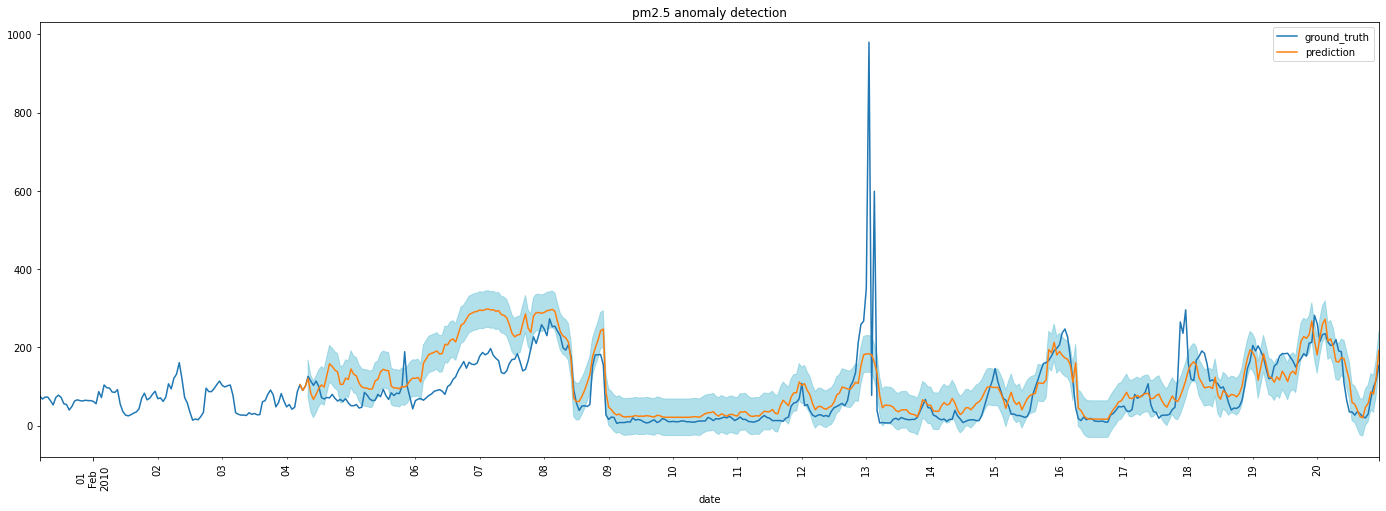

In [20]:
from matplotlib import pyplot as plt
margin=mae
df3.iloc[700:1200,:].plot(subplots=False, figsize=(24, 8),rot=90)
fill_alpha = 0.5
fill_color = '#66C2D7'
xticks=df3.iloc[m:n,:].index
lower=df3.iloc[m:n,1]-margin
upper=df3.iloc[m:n,1]+margin
plt.fill_between(xticks, lower, upper, color=fill_color, alpha=fill_alpha, label='95% CI')
plt.title('pm2.5 anomaly detection')